In [2]:
import torch
import numpy as np
from torch import nn
from PIL import Image
import torch.nn.functional as F
from typing import Tuple, Union
from collections import OrderedDict

import clip
from clip import tokenize
from dilated_model import ModifiedSpatialResNetDilated
from clip.model import CLIP, convert_weights, ModifiedResNet, AttentionPool2d

In [3]:
def linear(x, weight, bias):
    x = x.matmul(weight.t())
    x += bias
    return x

class AttentionSpatial2d(AttentionPool2d):
    def __init__(self, spacial_dim: int, embed_dim: int,
                 num_heads: int, output_dim: int = None, use_pos_enc: bool = False):
        super().__init__(spacial_dim, embed_dim, num_heads, output_dim)
        self.use_pos_enc = use_pos_enc
        assert not use_pos_enc  # TODO: add support for positional encoding.

    def forward(self, x):
        n, c, h, w = x.shape
        x = x.reshape(n, c, h*w).permute(2, 0, 1)  # NCHW -> (HW)NC
        # Without Positional Encoding.
        x = linear(x, self.v_proj.weight, self.v_proj.bias)
        x = linear(x, self.c_proj.weight, self.c_proj.bias)
        x = x.permute(1, 2, 0).reshape(n, -1, h, w)
        return x

class ModifiedSpatialResNet(ModifiedResNet):
    def __init__(self, layers, output_dim, heads, input_resolution=224, width=64):
        super().__init__(layers, output_dim, heads, input_resolution, width)
        # Override the Self Attention Pooling to Spatial Prediction.
        embed_dim = width * 32
        self.attnpool = AttentionSpatial2d(input_resolution // 32, embed_dim, heads, output_dim)

In [8]:
class SpatialCLIP(nn.Module):
    def __init__(self, high_res: bool=True, temperature=0.03) -> None:
        super(SpatialCLIP, self).__init__()
        self.high_res = high_res
        self.temperature = temperature
        self.clip_model, self.im_preprocess = clip.load('RN50')
        state_dict = self.clip_model.state_dict()

        # Infer model config from state dict
        counts = [len(set(k.split(".")[2] for k in state_dict if k.startswith(f"visual.layer{b}"))) for b in [1, 2, 3, 4]]
        vision_layers = tuple(counts)
        vision_width = state_dict["visual.layer1.0.conv1.weight"].shape[0]
        output_width = round((state_dict["visual.attnpool.positional_embedding"].shape[0] - 1) ** 0.5)
        assert output_width ** 2 + 1 == state_dict["visual.attnpool.positional_embedding"].shape[0]
        image_resolution = output_width * 32
        embed_dim = state_dict["text_projection"].shape[1]
        vision_heads = vision_width * 32 // 64
        embed_dim = self.clip_model.text_projection.shape[1]

        visual_block = ModifiedSpatialResNetDilated if high_res else ModifiedSpatialResNet
        # visual_block = ModifiedSpatialResNet
        self.clip_model.visual = visual_block(layers=vision_layers,
                                    output_dim=embed_dim,
                                    heads=vision_heads,
                                    input_resolution=image_resolution,
                                    width=vision_width)
        # convert_weights(self.clip_model)
        self.clip_model.load_state_dict(state_dict, strict=False)
    
    def encode_text(self, text):
        return self.clip_model.encode_text(text)
    
    def encode_image(self, image):
        with torch.no_grad():
            im = image.type(self.clip_model.dtype)
            # pad image to remove boundary effect
            pad = 64  # heuristic pad size
            pad = (pad, pad, pad, pad)
            padded_im = F.pad(im, pad, 'constant', 0)
            # get features
            features = self.clip_model.encode_image(padded_im)
            print('encoded')
            # crop out center to remove pad
            if self.high_res:
                target_size_h, target_size_w = im.size(-2), im.size(-1)
            else:
                target_size_h, target_size_w = im.size(-2) // 32, im.size(-1) // 32
            # compute new pad size
            pad_h = (features.size(-2) - target_size_h) // 2
            pad_w = (features.size(-1) - target_size_w) // 2
            features = features[:, :, pad_h:pad_h+target_size_h, pad_w:pad_w+target_size_w]
            # interpolate back to 224x224, use nearest to reproduce denseclip
            features = F.upsample(features,
                                  size=(im.size(-2), im.size(-1)),
                                  mode='bilinear',
                                  align_corners=None)  # 1xCxHxW
            assert features.size(0) == 1

            return features  # 1xCxHxW

    def forward(self, im, text):
        return
    
    def get_heatmap(self, im: Image, texts, resize=True):
        with torch.no_grad():
            im = im.convert('RGB')
            if resize:
                im = im.resize((224, 224))
            im = self.im_preprocess(im).unsqueeze(0)
            image_features = self.encode_image(im)  # 1xCxHxW

            texts_encoded = clip.tokenize(texts)
            text_features = self.clip_model.encode_text(texts_encoded)

            image_features = image_features / image_features.norm(dim=1, keepdim=True)
            text_features = text_features / text_features.norm(dim=1, keepdim=True)

            heatmap = (image_features * text_features[:, :, None, None]).sum(1)
            heatmap = heatmap.cpu().float().numpy()

            heatmap = np.exp(heatmap / self.temperature)

        return heatmap

In [9]:
model = SpatialCLIP(high_res=False, temperature=0.03)

In [17]:
im = Image.open('datasets/custom_images/Common_Yellowthroat_0045_190563.jpg')
texts = ['yellow fur', 'black beak', 'whitetree branch']
with torch.no_grad():
    heatmap = model.get_heatmap(im, texts)

encoded


/opt/homebrew/Caskroom/miniforge/base/envs/research/lib/python3.12/site-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


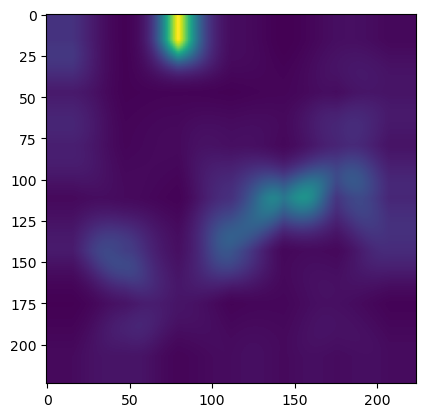

In [19]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(heatmap[0])
plt.show()

In [20]:
heatmap.shape

(3, 224, 224)